In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
query = """
SELECT * 
FROM nppes as np
join npi as n
on np.NPI = n.from_npi
WHERE np.CBSA = 34980

"""
with sqlite3.connect('../data/npidata.sqlite') as db:
    nppes_nashville = pd.read_sql(query, db)

In [3]:
db = sqlite3.connect('../data/npidata.sqlite')

query = '''
SELECT *
FROM npi
'''

hop_teams_npi = pd.read_sql(query,db)
db.close()

In [4]:
db = sqlite3.connect('../data/npidata.sqlite')

query = '''
SELECT *
FROM nppes
'''

hop_teams_nppes = pd.read_sql(query,db)
db.close()

### Created a dataframe with the unique NPI's and their respective providers, so we can have a from/to provider column for easier analysis

In [5]:
# Subset data to facilities and providers
all_facilities = hop_teams_nppes[hop_teams_nppes['Entity Type Code'] == 2.0]
all_providers = hop_teams_nppes[hop_teams_nppes['Entity Type Code'] == 1.0]
# Filling all nulls with blank string
all_providers = all_providers.fillna('')
all_providers['Provider Full Name'] = \
all_providers['Provider Name Prefix Text'] + \
all_providers['Provider First Name'] + ' ' + \
all_providers['Provider Middle Name'] + ' ' + \
all_providers['Provider Last Name (Legal Name)'] + ' ' + \
all_providers['Provider Name Suffix Text'] + ' ' + \
all_providers['Provider Credential Text']
# Creating a dictionary for all the Business NPI's
npi_to_business = dict(zip(all_facilities['NPI'],all_facilities['Provider Organization Name (Legal Business Name)']))
# Creating a dictionary for all the Provider NPI's
npi_to_provider = dict(zip(all_providers['NPI'],all_providers['Provider Full Name']))
# Combining the Business and Provider dictionary
all_npi_classification = npi_to_business | npi_to_provider

# Create dataframe with the NPI's and their respective provider
npi_to_name = pd.DataFrame({'npi':list(all_npi_classification.keys()),
                    'name':list(all_npi_classification.values())})

### I didn't get these lists in an efficient way
### For competitor_hospitals, I grabbed any name with Saint Thomas, St Thomas, Centennial, Tristar, and Nashville General hospital
### For tri star hospitals, I grabbed any name with Tristar
### For vanderbilt hospitals, I grabbed any name with Vanderbilt

In [7]:
competitor_hospitals = ['ENDOSCOPY CENTER OF ST THOMAS LLC',
       'SAINT THOMAS CAMPUS SURGICARE LP',
       'SAINT THOMAS OUTPATIENT NEUROSURGICAL CENTER',
       'SAINT THOMAS MEDICAL PARTNERS', 'SAINT THOMAS WEST HOSPITAL',
       'SAINT THOMAS HICKMAN HOSPITAL', 'SAINT THOMAS RX LLC',
       'SAINT THOMAS RUTHERFORD HOSPITAL',
       'SAINT THOMAS HOME HEALTH, INC.', 'SAINT THOMAS CLINIC PLLC',
       'SAINT THOMAS HEALTH', 'SAINT THOMAS HIGHLANDS HOSPITAL, LLC',
       'SAINT THOMAS RIVER PARK HOSPITAL, LLC',
       'SAINT THOMAS STONES RIVER HOSPITAL, LLC',
       'SAINT THOMAS DEKALB HOSPITAL, LLC', 'SAINT THOMAS CARE PLUS LLC',
                        'CENTENNIAL SURGERY CENTER LP',
       'COLUMBIA MEDICAL GROUP-CENTENNIAL INC',
       'CENTENNIAL SURGICAL ASSOCIATES LLC', 'CENTENNIAL HEART LLC',
       'CENTENNIAL PSYCHIATRIC ASSOCIATES, LLC',
       'CENTENNIAL NEUROSCIENCE, LLC', 'CENTENNIAL SURGICAL CLINIC, LLC',
       'TRISTAR MEDICAL GROUP - CENTENNIAL PRIMARY CARE, LLC',
       'CENTENNIAL HOSPITALISTS, LLC', 'CENTENNIAL WOMENS GROUP, LLC', 'TRISTAR CARDIOVASCULAR SURGERY LLC',
       'TRISTAR MEDICAL GROUP - CENTENNIAL PRIMARY CARE, LLC',
       'TRISTAR RADIATION ONCOLOGY, LLC',
       'TRISTAR GYNECOLOGY ONCOLOGY, LLC',
       'TRISTAR JOINT REPLACEMENT INSTITUTE, LLC',
       'TRISTAR BONE MARROW TRANSPLANT, LLC', 'TRISTAR FAMILY CARE, LLC',
                      'NASHVILLE GENERAL HOSPITAL' ]

tri_star_hospitals = ['TRISTAR CARDIOVASCULAR SURGERY LLC',
       'TRISTAR MEDICAL GROUP - CENTENNIAL PRIMARY CARE, LLC',
       'TRISTAR RADIATION ONCOLOGY, LLC',
       'TRISTAR GYNECOLOGY ONCOLOGY, LLC',
       'TRISTAR JOINT REPLACEMENT INSTITUTE, LLC',
       'TRISTAR BONE MARROW TRANSPLANT, LLC', 'TRISTAR FAMILY CARE, LLC',
       'TRISTAR MEDICAL GROUP - LEGACY HEALTH, LLC']

vanderbilt_hospitals = ['VANDERBILT STALLWORTH REHABILITATION HOSPITAL LP',
       'VANDERBILT UNIVERSITY MEDICAL CENTER',
       'VANDERBILT IMAGING SERVICES, LLC',
       'VANDERBILT HEALTH AND WILLIAMSON MEDICAL CENTER CLINICS AND SERVICES,',
       'VANDERBILT HOME CARE SERVICES, LLC',
       'VANDERBILT MAURY RADIATION ONCOLOGY, LLC']

In [8]:
to_npi_to_name = npi_to_name.rename(columns = {'npi' : 'to_npi'})
npi_to_name = npi_to_name.rename(columns = {'npi': 'NPI', 'name': 'from_provider'})

In [9]:
#Create to business/provider column
nppes_nashville = nppes_nashville.merge(right = to_npi_to_name, how = 'left', on = 'to_npi')

In [10]:
#Create from business_provider column
nppes_nashville = nppes_nashville.merge(right = npi_to_name, how = 'left', on ='NPI')

## What providers should Vanderbilt reach out to in the Nashville area if they want to increase their patient volume from Orthopedic Surgeons or from Family Medicine doctors

### Plan:
- Find all hospitals that are in the Nashville area
- Group by specialty (classification column) and get the total patient count for each specialty
- Subset for the Orthopedic Surgeons and Family Medicine doctors
- Then divide by the specialty to get the specific providers
- Highlight the top providers for each specialty and make a nice chart

### Side question: What percentage of referrals in the nashville area are to Vanderbilt?

In [51]:
nppes_nashville.groupby('Provider Organization Name (Legal Business Name)')['patient_count'].sum() \
.reset_index() \
.sort_values(by = 'patient_count', ascending = False) \
.reset_index(drop = True) \
.head(10)

,Provider Organization Name (Legal Business Name),patient_count
0,VANDERBILT UNIVERSITY MEDICAL CENTER,1851781
1,"ASSOCIATED PATHOLOGISTS, LLC",1810922
2,"PATHGROUP LABS, LLC",1298415
3,ASSOCIATED PATHOLOGISTS LLC,1266284
4,"ADVANCED DIAGNOSTIC IMAGING, PC",1149821
5,RADIOLOGY ALLIANCE PC,1078933
6,SAINT THOMAS MEDICAL PARTNERS,974598
7,TENNESSEE ONCOLOGY PLLC,919641
8,"HCA HEALTH SERVICES OF TENNESSEE, INC.",684234
9,CENTENNIAL HEART LLC,556358


In [49]:
nppes_nashville.groupby('name')['patient_count'].sum() \
.reset_index() \
.sort_values(by = 'patient_count', ascending = False) \
.reset_index(drop = True) \
.head(10)

,name,patient_count
0,VANDERBILT UNIVERSITY MEDICAL CENTER,1601942
1,"ADVANCED DIAGNOSTIC IMAGING, PC",937859
2,"ASSOCIATED PATHOLOGISTS, LLC",858715
3,SAINT THOMAS MEDICAL PARTNERS,793219
4,TENNESSEE ONCOLOGY PLLC,698197
5,RADIOLOGY ALLIANCE PC,693573
6,ASSOCIATED PATHOLOGISTS LLC,668968
7,"HCA HEALTH SERVICES OF TENNESSEE, INC.",613666
8,"PATHGROUP LABS, LLC",506427
9,DR.DEREK C. WELCH M.D.,506236


### What are the top 10 providers/facilities patients are being referred to in the Nashville area?
### How many in the top 10 are providers and not facilities?
### Is Vanderbilt in that top 10?
### How many providers / facilities are there in the Nashville area?

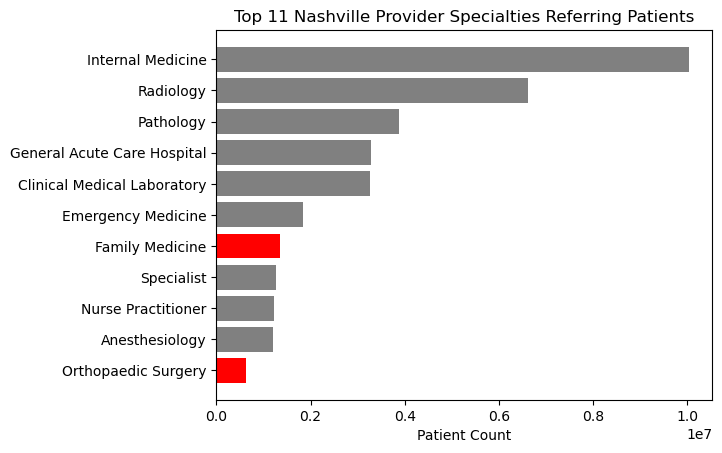

In [74]:
#What are the specialties of providers that are referring mass numbers to providers
specialties_to_nashville = nppes_nashville.groupby('Classification')['patient_count'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count', ascending = False) \
.reset_index(drop = True)

# Top 10 specialties that are sending patients to Nashville
specialties_to_nashville = specialties_to_nashville.sort_values(by = 'patient_count', ascending = False)

top_11_specialties_to_nashville = specialties_to_nashville.head(11)

top_11_color = ['red','grey','grey','grey','red','grey','grey','grey','grey','grey','grey']

#Create bar graph of patient referral to all hospitals (Top 10)
top_11_specialties_to_nashville = top_11_specialties_to_nashville.sort_values(by = 'patient_count', ascending = True)

plt.barh(data = top_11_specialties_to_nashville, 
         y = 'Classification', 
         width = 'patient_count', 
         color = top_11_color)

plt.xlabel('Patient Count')
#plt.ylabel('Specialty')
plt.title('Top 11 Nashville Provider Specialties Referring Patients', loc = 'center')

plt.savefig('../data/top_11_specialties_to_nashville.png',bbox_inches = 'tight')

### How many specialties are there in the Nashville area?

In [62]:
nppes_nashville['Classification'].nunique()

91

There are 91 different specialties within Nashville Providers

### How do orthopedic surgeons and family medicine rank?

In [83]:
ortho_fam_med_rank = specialties_to_nashville.query(
    "Classification == 'Family Medicine' | Classification == 'Orthopaedic Surgery' | Classification == 'Internal Medicine'"
)

ortho_fam_med_rank

,Classification,patient_count
0,Internal Medicine,10029126
6,Family Medicine,1342581
10,Orthopaedic Surgery,636885


### What percentage of patient referrals do they contribute for Nashville Providers?

In [84]:
nashville_total_patient_referrals = specialties_to_nashville['patient_count'].sum()
nashville_total_patient_referrals

40623780

In [85]:
ortho_fam_med_rank['specialty_share'] = (ortho_fam_med_rank['patient_count'] / nashville_total_patient_referrals) * 100
ortho_fam_med_rank

C:\Users\kidsa\AppData\Local\Temp\ipykernel_17560\2551844671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ortho_fam_med_rank['specialty_share'] = (ortho_fam_med_rank['patient_count'] / nashville_total_patient_referrals) * 100


,Classification,patient_count,specialty_share
0,Internal Medicine,10029126,24.687821
6,Family Medicine,1342581,3.304914
10,Orthopaedic Surgery,636885,1.567764


- There are 40.6 million patient referrals from Nashville Providers
- There are 91 different specialties within Nashville Providers
- The Nashville Provider specialty that is referring the most patients is Internal Medicine at 25%
- Family Medicine is referring 3.3% of all patients
- Orthopaedic Surgery is referring 1.6% of all patients

### Finding the Orthopedic surgeons Vanderbilt should reach out to

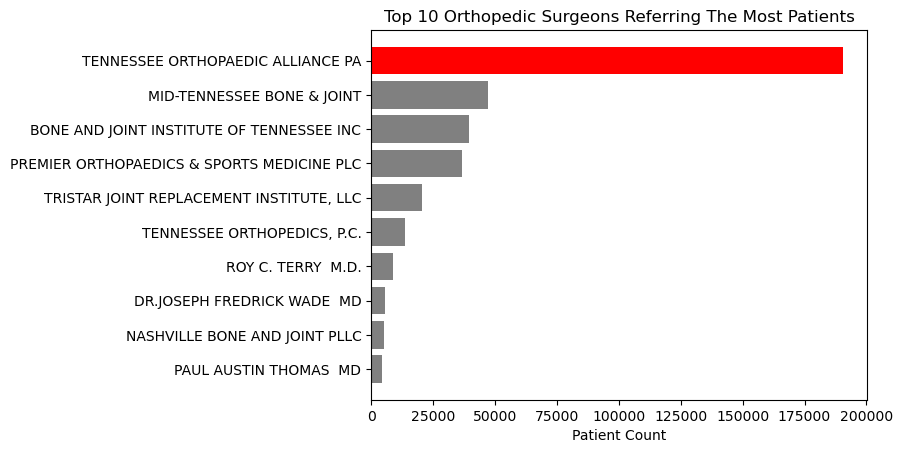

In [108]:
# Finding total patient referrals for all orthopedic surgeons
nashville_orthopedics = nppes_nashville.groupby(['Classification','from_provider']) \
['patient_count'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count', ascending = False) \
.reset_index(drop = True) \
.query('Classification == "Orthopaedic Surgery"')

#Sorting values to get top orthopedic surgeons
nashville_orthopedics = nashville_orthopedics.sort_values(by = 'patient_count', ascending = True)

top_10_nashville_orthopedics = nashville_orthopedics.sort_values(
    by = 'patient_count', ascending = False
) \
.head(10) \
.reset_index(drop = True) \
.sort_values(by = 'patient_count', ascending = True)

top_10_color = ['grey','grey','grey','grey','grey','grey','grey','grey','grey','red']

#Creating bar graph of top 10 Nashville Orthopedic Surgeons
plt.barh(data = top_10_nashville_orthopedics, y = 'from_provider', width = 'patient_count', color = top_10_color)

plt.xlabel('Patient Count')
#plt.ylabel('Specialty')
plt.title('Top 10 Orthopedic Surgeons Referring The Most Patients')


plt.savefig('../data/top_10_orthopedic_surgeons_referring_the_most_patients.png', bbox_inches = 'tight')

###  How many patients referred by orthopedic surgeons?
### What percentage is the top one and the second?

In [106]:
total_patients_referred_from_ortho = nashville_orthopedics['patient_count'].sum()
total_patients_referred_from_ortho

636885

In [105]:
top_10_nashville_orthopedics['% of total patients'] = (top_10_nashville_orthopedics['patient_count'] / total_patients_referred_from_ortho) * 100

top_10_nashville_orthopedics

,Classification,from_provider,patient_count,% of total patients
9,Orthopaedic Surgery,PAUL AUSTIN THOMAS MD,4581,0.719282
8,Orthopaedic Surgery,NASHVILLE BONE AND JOINT PLLC,5028,0.789467
7,Orthopaedic Surgery,DR.JOSEPH FREDRICK WADE MD,5665,0.889486
6,Orthopaedic Surgery,ROY C. TERRY M.D.,8860,1.391146
5,Orthopaedic Surgery,"TENNESSEE ORTHOPEDICS, P.C.",13829,2.171350
4,Orthopaedic Surgery,"TRISTAR JOINT REPLACEMENT INSTITUTE, LLC",20673,3.245955
3,Orthopaedic Surgery,PREMIER ORTHOPAEDICS & SPORTS MEDICINE PLC,36614,5.748919
2,Orthopaedic Surgery,BONE AND JOINT INSTITUTE OF TENNESSEE INC,39635,6.223259
1,Orthopaedic Surgery,MID-TENNESSEE BONE & JOINT,47059,7.388932
0,Orthopaedic Surgery,TENNESSEE ORTHOPAEDIC ALLIANCE PA,190731,29.947479


- 636,885 patients referred by orthopedic surgeons
- Tennessee Orthopaedic Alliance PA refers 30% of all orthopedic surgery patients
- Mid-Tennessee Bone & Joint is the next best referring 7%

### How many different orthopedic surgeons are there referring from the Nashville area?

- There are 205 orthopedic surgeons referring patients from the Nasvhille area

### Finding the Orthopedic surgeons Vanderbilt should reach out to

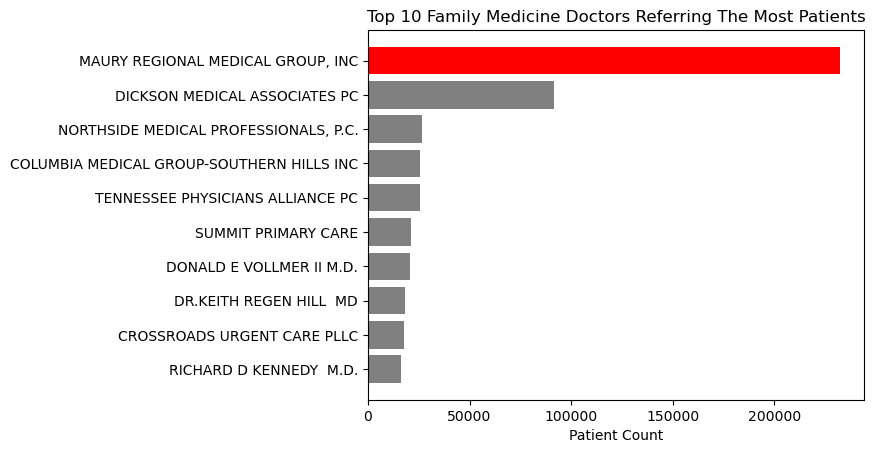

In [110]:
# Finding total patient referrals for all family medicine doctors
nashville_fam_med = nppes_nashville.groupby(['Classification','from_provider']) \
['patient_count'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count', ascending = False) \
.reset_index(drop = True) \
.query('Classification == "Family Medicine"')

#Sorting values to get top family medicine doctors
nashville_fam_med = nashville_fam_med.sort_values(by = 'patient_count', ascending = True)

top_10_nashville_fam_med = nashville_fam_med.sort_values(
    by = 'patient_count', ascending = False
) \
.head(10) \
.reset_index(drop = True) \
.sort_values(by = 'patient_count', ascending = True)

top_10_color = ['grey','grey','grey','grey','grey','grey','grey','grey','grey','red']

#Creating bar graph of top 10 Nashville Orthopedic Surgeons
plt.barh(data = top_10_nashville_fam_med, y = 'from_provider', width = 'patient_count', color = top_10_color)

plt.xlabel('Patient Count')
#plt.ylabel('Specialty')
plt.title('Top 10 Family Medicine Doctors Referring The Most Patients')


plt.savefig('../data/orthopedic_surgeons_referring_the_most_patients.png', bbox_inches = 'tight')

In [111]:
total_patients_referred_from_fam_med = nashville_fam_med['patient_count'].sum()
total_patients_referred_from_fam_med

1342581

In [112]:
top_10_nashville_fam_med['% of total patients'] = (top_10_nashville_fam_med['patient_count'] / total_patients_referred_from_fam_med) * 100

top_10_nashville_fam_med

,Classification,from_provider,patient_count,% of total patients
9,Family Medicine,RICHARD D KENNEDY M.D.,16173,1.204620
8,Family Medicine,CROSSROADS URGENT CARE PLLC,17688,1.317462
7,Family Medicine,DR.KEITH REGEN HILL MD,18371,1.368335
6,Family Medicine,DONALD E VOLLMER II M.D.,20756,1.545977
5,Family Medicine,SUMMIT PRIMARY CARE,21420,1.595434
4,Family Medicine,TENNESSEE PHYSICIANS ALLIANCE PC,25557,1.903572
3,Family Medicine,COLUMBIA MEDICAL GROUP-SOUTHERN HILLS INC,25578,1.905136
2,Family Medicine,"NORTHSIDE MEDICAL PROFESSIONALS, P.C.",26788,1.995261
1,Family Medicine,DICKSON MEDICAL ASSOCIATES PC,91425,6.809645
0,Family Medicine,"MAURY REGIONAL MEDICAL GROUP, INC",232581,17.323424


In [113]:
nashville_fam_med

,Classification,from_provider,patient_count
8963,Family Medicine,DR.RONALD IAN MCDERMOTT MD,13
8955,Family Medicine,SADIQA BOURA MD,14
8913,Family Medicine,DR.DIANE SIMONE MCDERMOTT MEDICAL DOCTOR,17
8902,Family Medicine,"AMERICA CARES TRUST, INC",18
8901,Family Medicine,DR.CYNTHIA ELIZABETH COLLINS MD,18
...,...,...,...
181,Family Medicine,TENNESSEE PHYSICIANS ALLIANCE PC,25557
180,Family Medicine,COLUMBIA MEDICAL GROUP-SOUTHERN HILLS INC,25578
171,Family Medicine,"NORTHSIDE MEDICAL PROFESSIONALS, P.C.",26788
43,Family Medicine,DICKSON MEDICAL ASSOCIATES PC,91425


###  How many patients referred by family medicine doctors?

### What percentage is the top one and the second?

### How many different family medicine doctors are there referring from the Nashville area?

- 1,342,581 total patients referred by family medicine doctors
- Maury Regional Medical Group INC refers 17% of all orthopedic surgery patients (number 1) About 2.5 times more than second best
- Dickson Medical Associates PC is the next best referring 7%
- There are 491 unique family medicine doctors referring from Nashville

In [13]:
#All providers that refer to Vanderbilt's competitor hospitals
refer_to_competitor = nppes_nashville[nppes_nashville['name'].isin(competitor_hospitals)]

In [14]:
# The specialties are the providers who are sending to competitor hospitals
refer_to_competitor.groupby('Classification')['patient_count'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count', ascending = False) \
.reset_index(drop = True)

,Classification,patient_count
0,Internal Medicine,644157
1,Radiology,342013
2,General Acute Care Hospital,138066
3,Emergency Medicine,101268
4,Anesthesiology,87669
...,...,...
65,Psychiatric Hospital,47
66,Dentist,46
67,Public Health or Welfare,41
68,Phlebology,40


In [15]:
# All providers that are sending to Vanderbilt
refer_to_vanderbilt = nppes_nashville[nppes_nashville['name'].isin(vanderbilt_hospitals)]

In [16]:
# The specialties are the providers who are sending to Vanderbilt
refer_to_vanderbilt.groupby('Classification')['patient_count'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count', ascending = False) \
.reset_index(drop = True)

,Classification,patient_count
0,Internal Medicine,545765
1,Radiology,242101
2,General Acute Care Hospital,126961
3,Nurse Practitioner,93262
4,Family Medicine,56250
...,...,...
62,Medical Genetics,108
63,Psychiatric Unit,101
64,Rehabilitation Unit,100
65,Licensed Practical Nurse,35


In [17]:
# All providers that are sending to TriStar
refer_to_tristar = nppes_nashville[nppes_nashville['name'].isin(tri_star_hospitals)]

In [18]:
# Creating dataframe of all providers that sent to Tristar or Vanderbilt
merged_tristar_vandy = refer_to_tristar.merge(
right = refer_to_vanderbilt,
how = 'left',
on = 'NPI')

### This filters to providers that are sending to TriStar but not Vanderbilt
### It shows the top specialties that are sending to TriStar

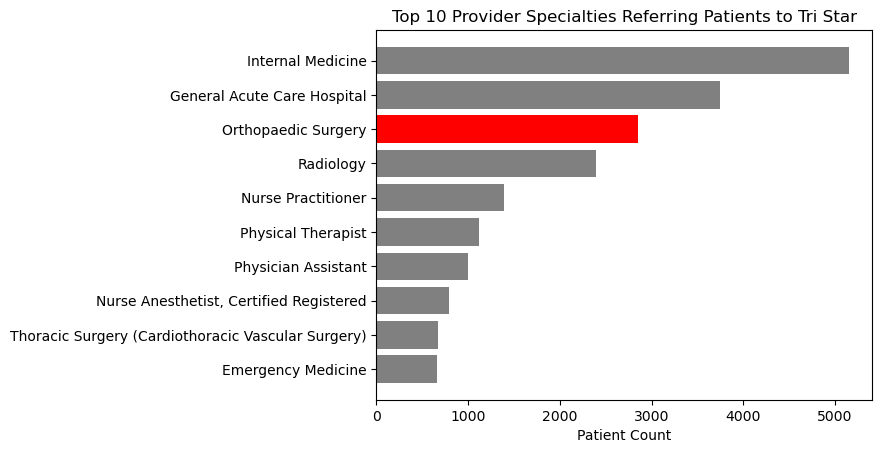

In [27]:
# Remove all providers that sent to Vanderbilt, so we can have only providers that sent to Tri-Star exclusively
sent_to_vandy_tri_star = merged_tristar_vandy[merged_tristar_vandy['name_y'].isna()]

#What are the specialties of providers that are sending mass numbers to TriStar
specialties_to_tristar = sent_to_vandy_tri_star.groupby('Classification_x')['patient_count_x'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count_x', ascending = False) \
.reset_index(drop = True)

# Top 10 specialties that are sending patients exclusively to tristar
specialties_to_tristar = specialties_to_tristar.sort_values(by = 'patient_count_x', ascending = False)

top_10_specialties_to_tristar = specialties_to_tristar.head(10)

top_10_color = ['grey','grey','grey','grey','grey','grey','grey','red','grey','grey']

#Create bar graph of patient referral to all hospitals (Top 10)
top_10_specialties_to_tristar = top_10_specialties_to_tristar.sort_values(by = 'patient_count_x', ascending = True)

plt.barh(data = top_10_specialties_to_tristar, 
         y = 'Classification_x', 
         width = 'patient_count_x', 
         color = top_10_color)

plt.xlabel('Patient Count')
#plt.ylabel('Specialty')
plt.title('Top 10 Provider Specialties Referring Patients to Tri Star', loc = 'center')

plt.savefig('../data/top_10_specialties_to_tristar.png',bbox_inches = 'tight')

### This filters to providers that are sending to TriStar and not Vanderbilt
### It shows the top providers that are sending to TriStar

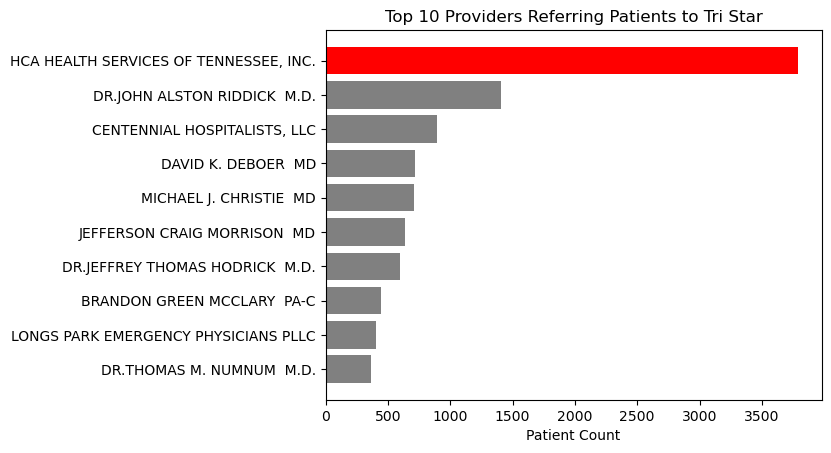

In [33]:
# Remove all providers that sent to Vanderbilt, so we can have only providers that sent to Tri-Star exclusively
sent_to_vandy_tri_star = merged_tristar_vandy[merged_tristar_vandy['name_y'].isna()]

#Which providers are sending to Tri-Star exclusively
providers_to_tristar = sent_to_vandy_tri_star.groupby('from_provider_x') \
['patient_count_x'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count_x', ascending = False) \
.reset_index(drop = True)

# Top 10 specialties that are sending patients exclusively to tristar
providers_to_tristar = providers_to_tristar.sort_values(by = 'patient_count_x', ascending = False)

top_10_providers_to_tristar = providers_to_tristar.head(10)

top_10_color = ['grey','grey','grey','grey','grey','grey','grey','grey','grey','red']

#Create bar graph of patient referral to all hospitals (Top 10)
top_10_providers_to_tristar = top_10_providers_to_tristar.sort_values(by = 'patient_count_x', ascending = True)

plt.barh(data = top_10_providers_to_tristar,
         y = 'from_provider_x',
         width = 'patient_count_x',
         color = top_10_color)

plt.xlabel('Patient Count')
#plt.ylabel('Specialty')
plt.title('Top 10 Providers Referring Patients to Tri Star', loc = 'center')

plt.savefig('../data/top_10_providers_to_tristar.png',bbox_inches = 'tight')

In [20]:
#Which providers are sending to Tri-Star exclusively
sent_to_vandy_tri_star.groupby('Provider Organization Name (Legal Business Name)_x')['patient_count_x'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count_x', ascending = False) \
.reset_index(drop = True)

,Provider Organization Name (Legal Business Name)_x,patient_count_x
0,"HCA HEALTH SERVICES OF TENNESSEE, INC.",3790
1,"CENTENNIAL HOSPITALISTS, LLC",895
2,LONGS PARK EMERGENCY PHYSICIANS PLLC,402
3,LEMMON EMERGENCY PHYSICIANS PLLC,216
4,"LAKESHORE ESTATES, INC.",140
5,INTEGUMETRIX,132
6,"HILLCREST HEALTHCARE, LLC",111
7,"EBENEZER HOME OF TENNESSEE, INC.",103
8,CHRISTIAN CARE CENTER OF CHEATHAM COUNTY INC,90
9,HILLCREST HEALTHCARE LLC,71


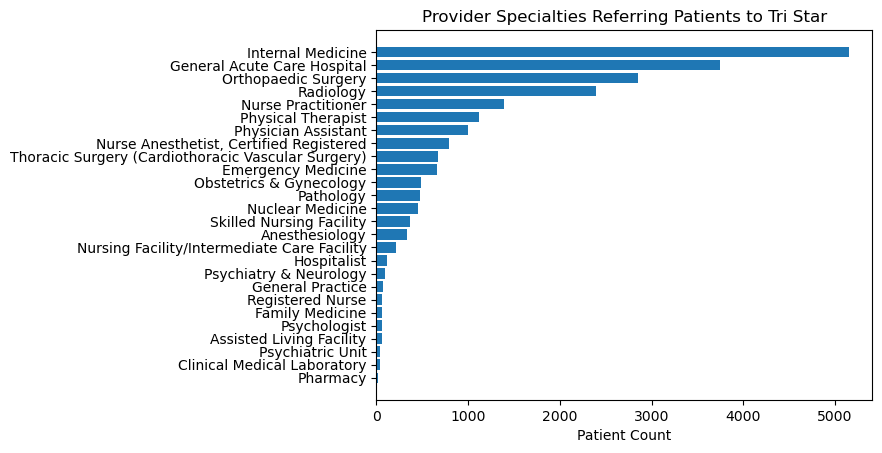

In [42]:
#Create bar graph of patient referral to all hospitals (Top 10)
specialties_to_tristar = specialties_to_tristar.sort_values(by = 'patient_count_x', ascending = True)

plt.barh(data = specialties_to_tristar, y = 'Classification_x', width = 'patient_count_x')

plt.xlabel('Patient Count')
#plt.ylabel('Specialty')
plt.title('Provider Specialties Referring Patients to Tri Star', loc = 'center', weight = )

plt.show()

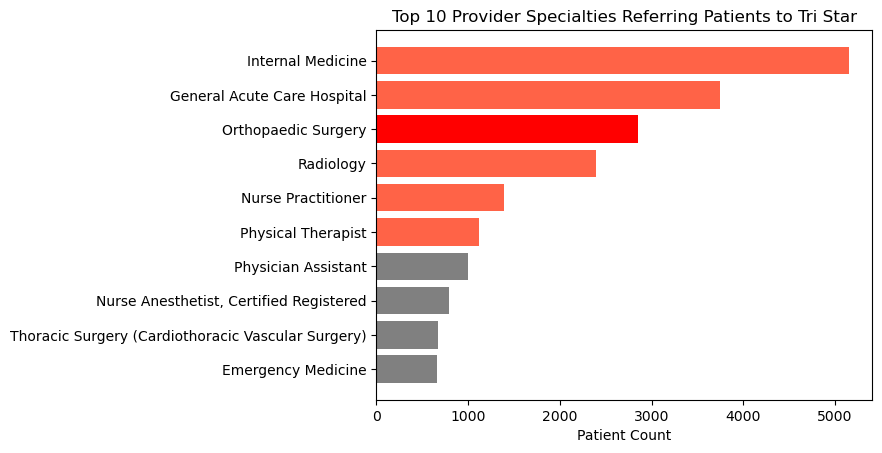

In [92]:
six_of_ten_color = ['grey','grey','grey','grey','tomato','tomato','tomato','red','tomato','tomato']

#Create bar graph of patient referral to all hospitals (six out of 10)
top_10_specialties_to_tristar = top_10_specialties_to_tristar.sort_values(by = 'patient_count_x', ascending = True)

plt.barh(data = top_10_specialties_to_tristar, y = 'Classification_x', width = 'patient_count_x', color = six_of_ten_color)

plt.xlabel('Patient Count')
#plt.ylabel('Specialty')
plt.title('Top 10 Provider Specialties Referring Patients to Tri Star', loc = 'center')

plt.savefig('../data/six_of_ten_specialties_to_tristar.png',bbox_inches = 'tight')

In [17]:
# refer_to_competitor.merge(right = refer_to_vanderbilt, how = 'left', on = 'NPI' )

In [19]:
# refer_to_vanderbilt.shape

(6495, 56)

In [20]:
# merged_competitors_vandy = refer_to_competitor.merge(
# right = refer_to_vanderbilt,
# how = 'left',
# on = 'NPI')

In [21]:
# # Providers that send only to vanderbilt competitors
# sent_to_vandy_comp = merged_competitors_vandy[merged_competitors_vandy['name_y'].isna()]
# sent_to_vandy_comp

In [22]:
# # Which providers are sending only to competitor hospitals
# sent_to_vandy_comp.groupby('Provider Organization Name (Legal Business Name)_x')['patient_count_x'] \
# .sum() \
# .reset_index() \
# .sort_values(by = 'patient_count_x', ascending = False)

In [66]:
# What orthopedic surgeons should Vanderbilt reach to?
orthopedic_sur = sent_to_vandy_tri_star.groupby(['Classification_x','from_provider_x']) \
['patient_count_x'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count_x', ascending = False) \
.reset_index(drop = True) \
.query('Classification_x == "Orthopaedic Surgery"')

orthopedic_sur

,Classification_x,from_provider_x,patient_count_x
3,Orthopaedic Surgery,DAVID K. DEBOER MD,719
4,Orthopaedic Surgery,MICHAEL J. CHRISTIE MD,709
5,Orthopaedic Surgery,JEFFERSON CRAIG MORRISON MD,635
6,Orthopaedic Surgery,DR.JEFFREY THOMAS HODRICK M.D.,597
27,Orthopaedic Surgery,DR.ROBERT JOEL OTTO M.D.,193


In [70]:
orthopedic_color = ['grey','grey','grey','grey','red']

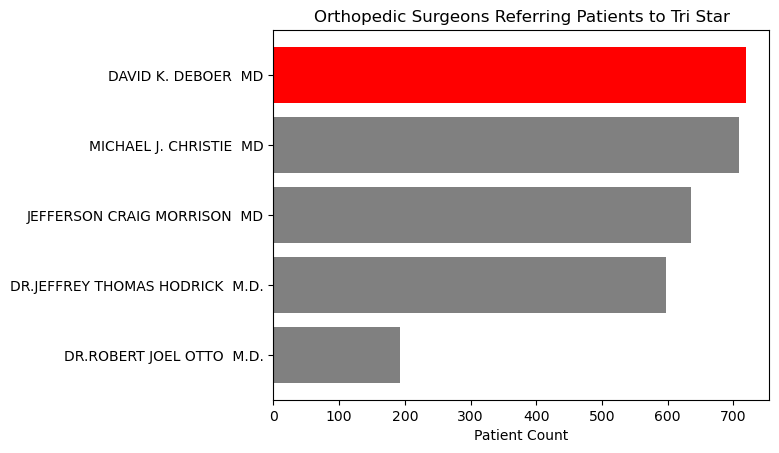

In [77]:
#Create bar graph of providers to reach out to for orthopedic surgery
orthopedic_sur = orthopedic_sur.sort_values(by = 'patient_count_x', ascending = True)

plt.barh(data = orthopedic_sur, y = 'from_provider_x', width = 'patient_count_x', color = orthopedic_color)

plt.xlabel('Patient Count')
#plt.ylabel('Specialty')
plt.title('Orthopedic Surgeons Referring Patients to Tri Star')


plt.savefig('../data/orthopedic_surgeons_tristar.png', bbox_inches = 'tight')

In [65]:
# What family medicine doctors should Vanderbilt reach to?
family_med = sent_to_vandy_tri_star.groupby(['Classification_x','from_provider_x']) \
['patient_count_x'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count_x', ascending = False) \
.reset_index(drop = True) \
.query('Classification_x == "Family Medicine"')

family_med

,Classification_x,from_provider_x,patient_count_x
89,Family Medicine,DR.CHRIS MEHR MD,59


In [147]:
# # Looking at the different providers that were Internal Medicine
# sent_to_vandy_tri_star.groupby(['Classification_x','from_provider','NPI']) \
# ['patient_count_x'] \
# .sum() \
# .reset_index() \
# .sort_values(by = 'patient_count_x', ascending = False) \
# .reset_index(drop = True).head(50) \
# .query('Classification_x == "Internal Medicine"')

,Classification_x,from_provider,NPI,patient_count_x
1,Internal Medicine,DR.JOHN ALSTON RIDDICK M.D.,1417131715,1404
2,Internal Medicine,"CENTENNIAL HOSPITALISTS, LLC",1558801332,895
15,Internal Medicine,THOMAS A TESAURO MD,1578501904,270
17,Internal Medicine,JACOB C DEXHEIMER MD,1518014323,266
18,Internal Medicine,VICTOR A VALLEJO MD,1679539886,241
19,Internal Medicine,DR.ROBERT M WHEATLEY M.D. F.A.C.C.,1558461970,236
30,Internal Medicine,JENNIFER P LEE MD,1922048883,189
32,Internal Medicine,THOMAS STEVAN JOHNSTON MD,1023103462,183
38,Internal Medicine,PHILIP S KUO MD,1639112048,144
40,Internal Medicine,JEFFREY C WEBBER MD,1235242181,141


In [150]:
refer_to_tristar

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,name
380,1275536468,1.0,None,ASAD,MUHAMMAD,None,DR.,None,MD,353 NEW SHACKLE ISLAND RD,SUITE 300 C,HENDERSONVILLE,TN,370752379.0,207RI0011X,N,207RC0000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207RC0000X,Internal Medicine,37075,34980,1275536468,1770851552,45,51,32.922,67.310,TRISTAR CARDIOVASCULAR SURGERY LLC
1568,1568464873,2.0,DICKSON MEDICAL ASSOCIATES PC,None,None,None,None,None,None,113 HIGHWAY 70 E,None,DICKSON,TN,370552080.0,207Q00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207Q00000X,Family Medicine,37055,34980,1568464873,1164834057,68,88,46.807,61.499,"TRISTAR JOINT REPLACEMENT INSTITUTE, LLC"
1759,1568464873,2.0,DICKSON MEDICAL ASSOCIATES PC,None,None,None,None,None,None,113 HIGHWAY 70 E,None,DICKSON,TN,370552080.0,207Q00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207Q00000X,Family Medicine,37055,34980,1568464873,1609326040,42,65,33.154,37.904,"TRISTAR FAMILY CARE, LLC"
1824,1568464873,2.0,DICKSON MEDICAL ASSOCIATES PC,None,None,None,None,None,None,113 HIGHWAY 70 E,None,DICKSON,TN,370552080.0,207Q00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207Q00000X,Family Medicine,37055,34980,1568464873,1770851552,46,63,12.810,20.686,TRISTAR CARDIOVASCULAR SURGERY LLC
2703,1215932413,2.0,"ANESTHESIA MEDICAL GROUP, PC",None,None,None,None,None,None,110 29TH AVE N,STE 301,NASHVILLE,TN,37203.0,207R00000X,N,207RP1001X,N,2081P2900X,N,208VP0000X,N,367500000X,N,207L00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207L00000X,Anesthesiology,37203,34980,1215932413,1003152208,274,324,17.222,42.241,"TRISTAR GYNECOLOGY ONCOLOGY, LLC"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [152]:
# Adding from provider column to Tristar dataframe
refer_to_tristar = refer_to_tristar.merge(right = npi_to_name, how = 'left', on = 'NPI')

In [159]:
refer_to_tristar.groupby(['Classification','from_provider','NPI']) \
['patient_count'] \
.sum() \
.reset_index() \
.sort_values(by = 'patient_count', ascending = False) \
.reset_index(drop = True).head(50) \
.query('Classification == "Orthopaedic Surgery"')

,Classification,from_provider,NPI,patient_count
12,Orthopaedic Surgery,DAVID K. DEBOER MD,1942265400,719
13,Orthopaedic Surgery,MICHAEL J. CHRISTIE MD,1841255346,709
15,Orthopaedic Surgery,JEFFERSON CRAIG MORRISON MD,1609831916,635
19,Orthopaedic Surgery,DR.JEFFREY THOMAS HODRICK M.D.,1265556674,597


In [168]:
#Finding Kagon's answers
nppes_nashville[nppes_nashville['from_provider'] == 'DICKSON MEDICAL ASSOCIATES PC'].groupby('Classification') \
['patient_count'] \
.sum()

Classification
Family Medicine    91425
Name: patient_count, dtype: int64

In [169]:
nppes_nashville[nppes_nashville['from_provider'] == ''].groupby('Classification') \
['patient_count'] \
.sum()

Series([], Name: patient_count, dtype: int64)